<a href="https://colab.research.google.com/github/shubhamsaloni/ML_model_wifi/blob/main/SSALONI_wifi_usage_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Model to predict user load on a Wi-Fi network

**Get Data**

In [699]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[Data Source](https://colab.research.google.com/drive/11Rxloq-DGeqrE-x-jrYBUQaPswa3E_Au#scrollTo=-BeMtI1IYaP9&line=2&uniqifier=1) 

**Description**: 
Purple wifi visitors count - hourly aggregation
This data has been generated and sourced from Telstra Purple, data represents counting the number of Wi-Fi signals emitted by non-identifiable mobile devices within a specified proximity and performing certain filtering and processing. It provides an indication of trends, activities and events within access point areas. It can be visualised on our People Counting dashboard.

Anyone using this data does so at their own risk. To the full extent permitted by law, Council is released from and will in no way be liable to you or anyone else for any loss however caused (including through negligence) suffered directly or indirectly as a result of any reliance on this data. All intellectual property rights are reserved.

Counting method: each device in counted only once within a given hour, however the same device can be counted multiple times within the same day. For example:

if the same device is identified twice at 715am and 730am, it is counted as one
if the same device is identified at 715am and 815pm, it is counted twice

In [700]:
# load data and libraries

import pandas as pd 
import statsmodels.api as sm
import matplotlib.pyplot as plt
from vega_datasets import data
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn import preprocessing
from sklearn.metrics import classification_report

wifi_data =  pd.read_csv("/content/drive/MyDrive/presence-aggregation.csv")
wifi_data.head()

,Device ID,time,DayOfWeek,presence,Geolocation,Device name,Device type,new,year,month,dev_id,datetime,organisation
0,3961,2022-04-30T13:00:00-07:00,Sunday,34,"-33.753266, 150.695952","482 High St Near Station St, Penrith",Telstra Purple WiFi,34.0,2022,May,3961,2022-04-30T13:00:00-07:00,Penrith City Council
1,3963,2022-04-30T13:00:00-07:00,Sunday,68,"-33.7536526, 150.6977007","Woodriff St near High St , Penrith",Telstra Purple WiFi,68.0,2022,May,3963,2022-04-30T13:00:00-07:00,Penrith City Council
2,3964,2022-04-30T13:00:00-07:00,Sunday,19,"-33.762416, 150.775023","Station St near Queen St, St Marys, Penrith",Telstra Purple WiFi,19.0,2022,May,3964,2022-04-30T13:00:00-07:00,Penrith City Council
3,3967,2022-04-30T13:00:00-07:00,Sunday,2,"-33.762724, 150.663763","Tench Reserve side, opposite 66 Tench Ave, Jam...",Telstra Purple WiFi,2.0,2022,May,3967,2022-04-30T13:00:00-07:00,Penrith City Council
4,3968,2022-04-30T13:00:00-07:00,Sunday,12,"-33.76045, 150.66701","Tench Reserve side, opposite southern end of 6...",Telstra Purple WiFi,12.0,2022,May,3968,2022-04-30T13:00:00-07:00,Penrith City Council


**Explore Data**

In [701]:
# drop unpopulated rows
wifi_data.dropna(inplace=True)

# Check details of the columns present in the dataset
for col in wifi_data.columns:
    print(col)


Device ID
time
DayOfWeek
presence
Geolocation
Device name
Device type
new
year
month
dev_id
datetime
organisation


In [702]:
# Check no. of data elements in the dataset
wifi_data.count()

Device ID       197555
time            197555
DayOfWeek       197555
presence        197555
Geolocation     197555
Device name     197555
Device type     197555
new             197555
year            197555
month           197555
dev_id          197555
datetime        197555
organisation    197555
dtype: int64

In [703]:
# Check Data information
wifi_data.time.value_counts()

2021-11-15T13:00:00-08:00    17
2021-12-20T08:00:00-08:00    17
2021-12-20T07:00:00-08:00    17
2021-11-03T15:00:00-07:00    17
2021-11-03T16:00:00-07:00    17
                             ..
2022-07-25T20:00:00-07:00     1
2022-07-25T22:00:00-07:00     1
2022-07-25T23:00:00-07:00     1
2022-07-26T01:00:00-07:00     1
2022-07-22T20:00:00-07:00     1
Name: time, Length: 13676, dtype: int64

In [704]:
wifi_data.presence.value_counts()

11     3341
12     3260
10     3236
13     3189
9      3102
       ... 
274       1
277       1
275       1
315       1
281       1
Name: presence, Length: 281, dtype: int64

In [705]:

wifi_data.Geolocation.value_counts()

-33.762724, 150.663763      13559
-33.76684, 150.774138       13329
-33.720688, 150.710861      13318
-33.753459, 150.696802      13314
-33.753266, 150.695952      13311
-33.7536526, 150.6977007    13301
-33.765825, 150.774239      13291
-33.76045, 150.66701        13227
-33.768347, 150.773718      13212
-33.762416, 150.775023      13017
-33.758373, 150.66447       11676
-33.752518, 150.692804      11153
-33.763602, 150.774487      10766
-33.765491, 150.769138       9871
-33.748258, 150.677903       7745
-33.766673, 150.688754       7424
-33.763653, 150.662747       6041
Name: Geolocation, dtype: int64

In [706]:
#Skip code unfriendly column names - Device name, Device type
wifi_data.new.value_counts()

11.0     3341
12.0     3260
10.0     3236
13.0     3189
9.0      3102
         ... 
274.0       1
277.0       1
275.0       1
315.0       1
281.0       1
Name: new, Length: 281, dtype: int64

In [707]:
wifi_data.year.value_counts()

2022    112871
2021     73467
2023     11217
Name: year, dtype: int64

In [708]:
wifi_data.month.value_counts()

Oct    20984
Aug    20765
Nov    20324
Jan    20197
Sep    19945
Dec    19406
Jul    19299
Feb    13720
Jun    12515
Mar    10405
May    10250
Apr     9745
Name: month, dtype: int64

In [709]:
wifi_data.dev_id.value_counts()

3967    13559
3969    13329
3978    13318
3962    13314
3961    13311
3963    13301
3974    13291
3968    13227
3975    13212
3964    13017
3976    11676
3960    11153
3973    10766
3971     9871
3977     7745
3965     7424
3966     6041
Name: dev_id, dtype: int64

In [710]:
wifi_data.datetime.value_counts()

2021-11-15T13:00:00-08:00    17
2021-12-20T08:00:00-08:00    17
2021-12-20T07:00:00-08:00    17
2021-11-03T15:00:00-07:00    17
2021-11-03T16:00:00-07:00    17
                             ..
2022-07-25T20:00:00-07:00     1
2022-07-25T22:00:00-07:00     1
2022-07-25T23:00:00-07:00     1
2022-07-26T01:00:00-07:00     1
2022-07-22T20:00:00-07:00     1
Name: datetime, Length: 13676, dtype: int64

In [711]:
wifi_data.organisation.value_counts()

Penrith City Council    197555
Name: organisation, dtype: int64

**Pre-Process Data**

In [712]:
#delete redundant columns 
del wifi_data['Device ID']
#delete single valued columns
del wifi_data['organisation']
#Picking DayOfWeek, Geolocation and month as independent variables and presence as dependent
#Remove other columns
del wifi_data['time'] 
del wifi_data['year']
del wifi_data['Device name']
del wifi_data['new']
del wifi_data['datetime']
del wifi_data['Device type']
del wifi_data['dev_id']
wifi_data.head()

,DayOfWeek,presence,Geolocation,month
0,Sunday,34,"-33.753266, 150.695952",May
1,Sunday,68,"-33.7536526, 150.6977007",May
2,Sunday,19,"-33.762416, 150.775023",May
3,Sunday,2,"-33.762724, 150.663763",May
4,Sunday,12,"-33.76045, 150.66701",May


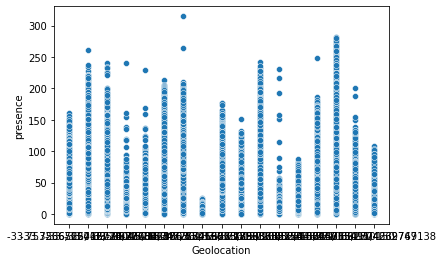

In [713]:
# Learn about dependent variable relationship with other independent variables
sns.scatterplot(y='presence', x='Geolocation', data=wifi_data)



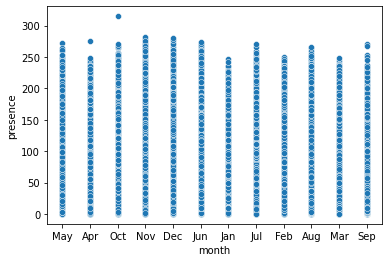

In [714]:
sns.scatterplot(y='presence', x='month', data=wifi_data)

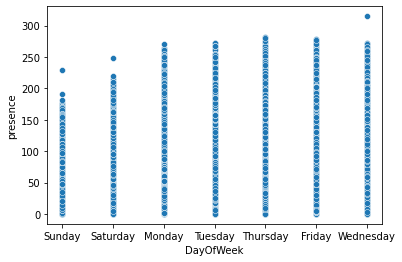

In [715]:
sns.scatterplot(y='presence', x='DayOfWeek', data=wifi_data)

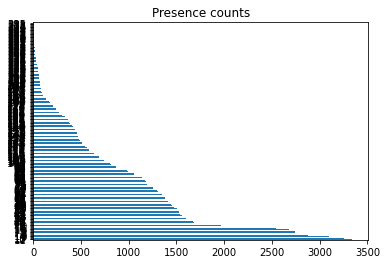

In [716]:
# check distribution of data in column - presence
wifi_data.presence.value_counts().plot(kind='barh', title='Presence counts')
plt.show()

In [717]:
# Since presence has continuous num value, for predictions convert data to high-load(1) and low-load(0) 
wifi_data['High_num_devices'] = np.where(wifi_data['presence']>50, '1', '0')
wifi_data.head()

,DayOfWeek,presence,Geolocation,month,High_num_devices
0,Sunday,34,"-33.753266, 150.695952",May,0
1,Sunday,68,"-33.7536526, 150.6977007",May,1
2,Sunday,19,"-33.762416, 150.775023",May,0
3,Sunday,2,"-33.762724, 150.663763",May,0
4,Sunday,12,"-33.76045, 150.66701",May,0


In [718]:
# check if data is divided evenly
wifi_data.High_num_devices.value_counts()


0    100671
1     96884
Name: High_num_devices, dtype: int64

In [719]:
 #delete presence
del wifi_data['presence']
wifi_data.head()

,DayOfWeek,Geolocation,month,High_num_devices
0,Sunday,"-33.753266, 150.695952",May,0
1,Sunday,"-33.7536526, 150.6977007",May,1
2,Sunday,"-33.762416, 150.775023",May,0
3,Sunday,"-33.762724, 150.663763",May,0
4,Sunday,"-33.76045, 150.66701",May,0


In [720]:
# Create dummy variables
categorical_cols = ['DayOfWeek', 'Geolocation', 'month']
wifi_data = pd.get_dummies(data = wifi_data, columns=categorical_cols, drop_first=False)
for col in wifi_data.columns:
    print(col)

High_num_devices
DayOfWeek_Friday
DayOfWeek_Monday
DayOfWeek_Saturday
DayOfWeek_Sunday
DayOfWeek_Thursday
DayOfWeek_Tuesday
DayOfWeek_Wednesday
Geolocation_-33.720688, 150.710861
Geolocation_-33.748258, 150.677903
Geolocation_-33.752518, 150.692804
Geolocation_-33.753266, 150.695952
Geolocation_-33.753459, 150.696802
Geolocation_-33.7536526, 150.6977007
Geolocation_-33.758373, 150.66447
Geolocation_-33.76045, 150.66701
Geolocation_-33.762416, 150.775023
Geolocation_-33.762724, 150.663763
Geolocation_-33.763602, 150.774487
Geolocation_-33.763653, 150.662747
Geolocation_-33.765491, 150.769138
Geolocation_-33.765825, 150.774239
Geolocation_-33.766673, 150.688754
Geolocation_-33.76684, 150.774138
Geolocation_-33.768347, 150.773718
month_Apr
month_Aug
month_Dec
month_Feb
month_Jan
month_Jul
month_Jun
month_Mar
month_May
month_Nov
month_Oct
month_Sep


In [721]:
wifi_data.head()


,High_num_devices,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,"Geolocation_-33.720688, 150.710861","Geolocation_-33.748258, 150.677903",...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


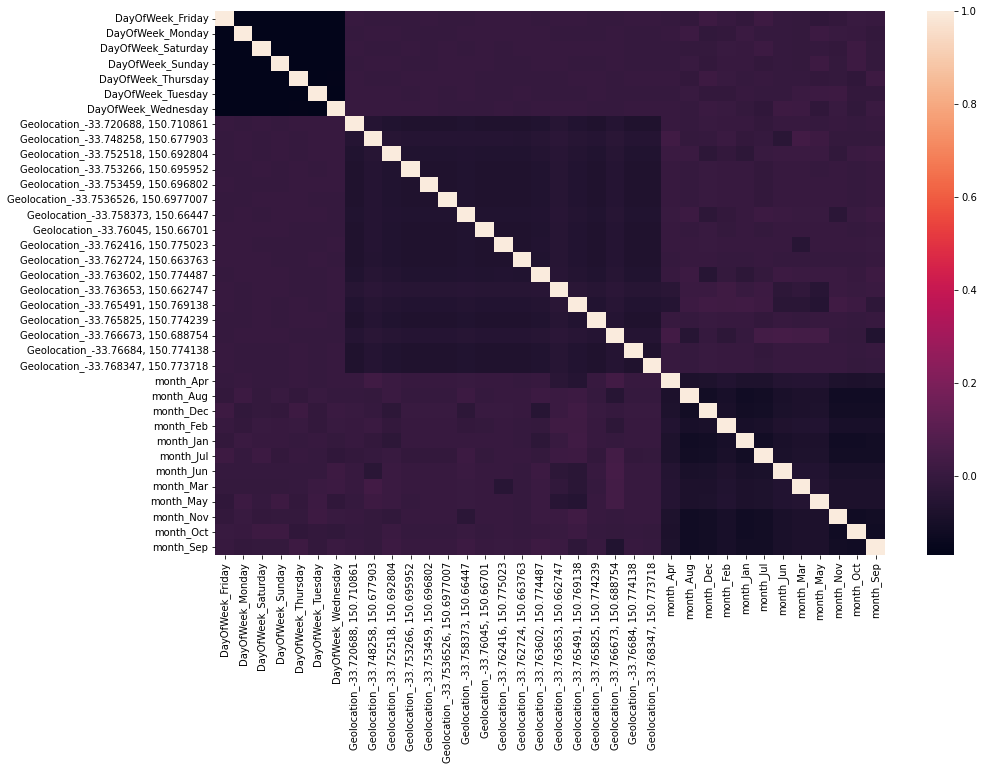

In [722]:
# Check if there is any correlation in independent variables
corr_matrix = wifi_data.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix)
plt.show()

The Independent variables do not look correlated, so no extra processing needed.

**Split Data for training model**

In [723]:
# get the dependent variable
y = wifi_data.pop('High_num_devices')
# independent variables
X = wifi_data

# Split dataset into 75:25, train:test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train.head()

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,"Geolocation_-33.720688, 150.710861","Geolocation_-33.748258, 150.677903","Geolocation_-33.752518, 150.692804",...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
134787,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
146667,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
81187,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
84460,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
149839,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


**Fit the model**

In [724]:
# for our prediction problem lets use LogisticRegression
# for regularization lets use penalty 12
model_lr = LogisticRegression(penalty='l2').fit(X_train, y_train)
# predict probabilities
predictions = model_lr.predict_proba(X_test)[:, 1]

**Check the model**

In [725]:
# Predict probabilities given test data
y_pred = model_lr.predict_proba(X_test)
y_pred

array([[0.03494878, 0.96505122],
       [0.92264656, 0.07735344],
       [0.06127202, 0.93872798],
       ...,
       [0.99490075, 0.00509925],
       [0.02856001, 0.97143999],
       [0.08022148, 0.91977852]])

In [726]:
# Confusion matrix

df_confusion = pd.crosstab(y_pred.round()[:,1], y_test, rownames=['Predicted'], colnames=['Actual'], margins=True)
df_confusion

Actual,0,1,All
Predicted,,,
0.0,20229,2148,22377
1.0,4902,22110,27012
All,25131,24258,49389


In [727]:
# get precision/recall and F1 score
pred_load = model_lr.predict(X_test)
print(classification_report(y_test, pred_load))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85     25131
           1       0.82      0.91      0.86     24258

    accuracy                           0.86     49389
   macro avg       0.86      0.86      0.86     49389
weighted avg       0.86      0.86      0.86     49389



We have fairly good precision/recall and f1-score for this model. Model looks accurate

In [728]:
# Check AUC ROC curve
def do_roc_curve(name, predictions, y_test):
  auc = roc_auc_score(y_test, predictions).round(2)
  fpr, tpr, _ = roc_curve(y_test, predictions)

  plt.figure(figsize=(8, 5))
  plt.plot([0, 1], [0, 1], linestyle='--')  # plot horizontal line 
  plt.plot(fpr, tpr, label='{} AUC = {}'.format(name, auc)) # plot the roc curve for the model
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend(loc='lower right')  # show the legend
  plt.show() # show the plot
  return None

 

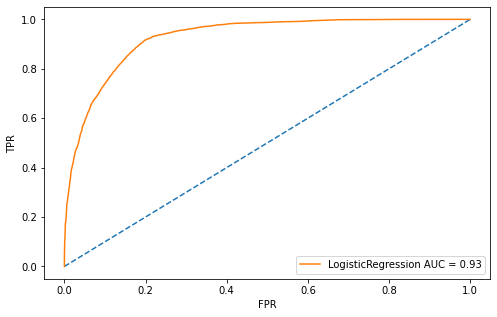

In [729]:
 #To prevent Erorr: Data is not binary and pos_label is not specified; make data binary
 y_test= '1' <= y_test
 # plot the curve
 do_roc_curve('LogisticRegression', predictions, y_test)

**More insights from the model**

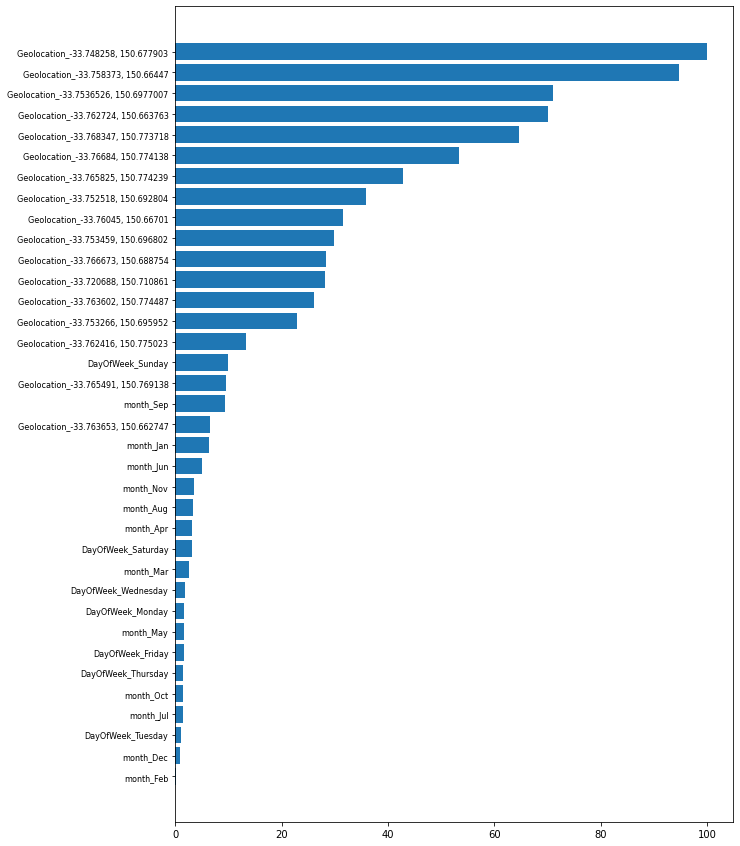

In [730]:
feature_importance = abs(model_lr.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10, 15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)

plt.show()

In deciding the user device load on the Wi-Fi network 

*   Geo-location is more important than month or day.
*   Amongst days, Sunday is most important 
*   Amongst months,  Jan has most impact in predicting






In [731]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


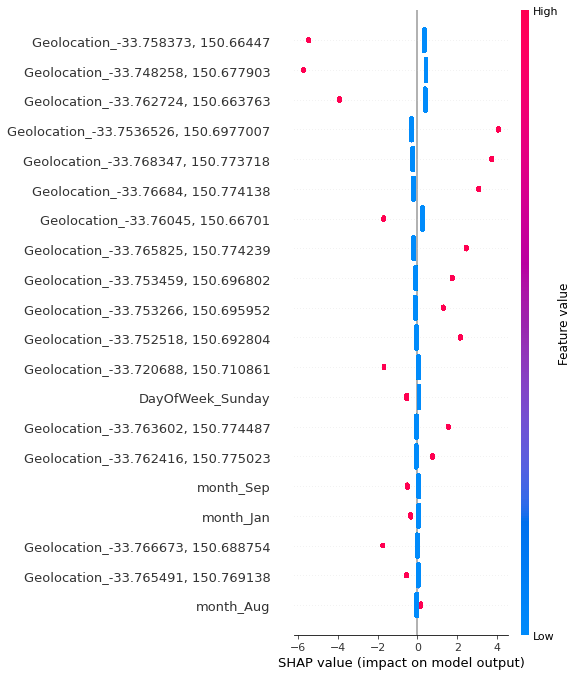

In [732]:
import shap
shap.initjs()

explainer = shap.LinearExplainer(model_lr, X)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

From Shap analysis taking in consideration value of data also, the following can be added to earlier conclusions:

  * Geo-location is more important than month or day: Few Geo locations that have more impact on the model have high load while others have low.
  * Amongst days, Sunday is most important : Sunday the load is lower
  * Amongst months, Jan has most impact in predicting : Jan the load is lower

Business Outcome from analysis by this ML model

  * **Capacity Planning**: Area with high user load can be deployed with more or high capacity Wi-Fi access points, and those with lower load with low capacity. We know which are what from shap analysis
  * **Maintainance Window**: Looks like a sunday in Jan will be best to do maintainance . And if a mid-year maintainance is needed a sunday in Sep will be good.

References:
1. Some code is copied from : https://colab.research.google.com/drive/1zPn-z4mBHJY1AOkndOe_ks0iba2oxuaC#scrollTo=rj61HvVXD5MS
2. https://stackoverflow.com/questions/18401112/valueerror-data-is-not-binary-and-pos-label-is-not-specified
